In [1]:
try:
    import google.colab
    !nvidia-smi -L
    !pip -q install pytorch_lightning
    google.colab.drive.mount('/content/drive/')
    %cd ../content/drive/Othercomputers/MyMacBookPro/CNN
    data_loc = '../../../MyDrive/DataFiles'
except:
    data_loc = '../../DataFiles' 
      
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
from torch.optim import lr_scheduler
import pytorch_lightning as pl
import albumentations as A
from torch.utils.data import TensorDataset
import torchmetrics
from torchmetrics import Metric
from torchview import draw_graph


from Read import read_data

### Initiate Model

/opt/anaconda3/envs/arm/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


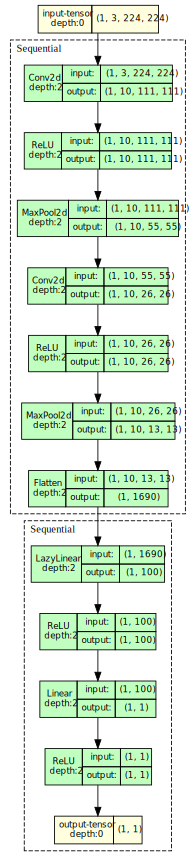

In [2]:
class ConvNet(pl.LightningModule):
    '''
    CNN Architecture Implementation
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.feature_extraction= nn.Sequential(
        
        nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=2), 
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5, stride=2), 
        nn.ReLU(), 
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Flatten()
        )
        self.feed_forward = nn.Sequential(
        nn.LazyLinear(100), nn.ReLU(),
        nn.Linear(100, 1), nn.ReLU(),
        )  
        self.loss_fun = nn.BCEWithLogitsLoss()

        self.accuracy = torchmetrics.Accuracy(task="binary")
        self.F1 = torchmetrics.F1Score(task="binary", average="macro")
        

    def forward(self, x):
        '''
        Forward method to pass a given input batch to the model and return its predictions
        '''
        x = self.feature_extraction(x)
        x = self.feed_forward(x)
        return x

# The following function allows us to extend the class in other celss
def ConvNetClass(func):
    setattr(ConvNet, func.__name__, func)
    return func

# Graph of the model
model_graph = draw_graph(ConvNet(), input_size=(1,3,224,224), expand_nested=True)
model_graph.visual_graph

### Read & Preprocess Data

In [3]:
new_size = 224
transforms = A.Compose([
            A.SmallestMaxSize(max_size=new_size),
            A.CenterCrop(new_size, new_size),
            A.Normalize(mean=[0.277, 0.277, 0.277], std=[0.254, 0.246, 0.223]),     # Computed by a script
        ])
x_data, y_data = read_data(data_loc, transform=transforms, saved=True)

In [4]:
@ConvNetClass
def prepare_data(self) :
    '''
    Converts x_data, y_data to torch tensors and splits the data into train and validation sets
    '''
    dataset = TensorDataset(torch.from_numpy(x_data).float(), torch.from_numpy(y_data).float())
    self.train_set, self.val_set = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)])
    
@ConvNetClass
def train_dataloader(self):
    '''
    Gives PyTorch a way to extract training batches from the training set
    '''
    return torch.utils.data.DataLoader(self.train_set, batch_size=64, shuffle=True, num_workers=2)

@ConvNetClass
def val_dataloader(self):
    '''
    Gives PyTorch a way to extract validation batches from the validation set
    '''
    return torch.utils.data.DataLoader(self.val_set, batch_size=32, shuffle=False, num_workers=2)
        

### Training

In [5]:
num_epochs = 30
lr = 0.01
@ConvNetClass
def configure_optimizers(self):
    '''
    Optimizer and Learning Scheduler for CNN training
    '''
    # PyTorch lightning takes a list of optimizers and a list of schedulers so 
    optimizers = [torch.optim.AdamW(self.parameters(), lr=lr), ]       
    schedulers = [lr_scheduler.OneCycleLR(optimizers[0], max_lr=lr, steps_per_epoch=len(self.train_dataloader()), epochs=num_epochs), ]
    return optimizers, schedulers

@ConvNetClass
def training_step(self, batch, batch_idx):
    '''
    At every epoch, for each batch in the training set, we want to:
    - Compute and return the loss so that the optimizer can update the weights
    - Compute training accuracy and loss for logging
    '''
    x, y = batch
    logits = self(x).flatten()
    loss = self.loss_fun(logits, y)
    
    acc = self.accuracy(logits, y)
    self.log("train_acc", acc, on_epoch=True, on_step=False, prog_bar=True)
    return loss

@ConvNetClass
def validation_step(self, batch, batch_idx):
    '''
    After every training epoch, a validation epoch runs. What to do for each batch in it:
    - Compute accuracy, validation loss and F1 score for logging
    '''
    x, y = batch
    logits = self(x).flatten()
    loss = self.loss_fun(logits, y)
    acc = self.accuracy(logits, y)
    F1 = self.F1(logits, y)
    self.log("val_acc", acc, on_epoch=True, prog_bar=True)
    self.log("val_F1", F1, on_epoch=True, prog_bar=True)
    return loss


In [6]:
model = ConvNet()
trainer = pl.Trainer(max_epochs=num_epochs, enable_checkpointing=False, logger=False)
trainer.fit(model)                      #fit performs the full optimization routine (train and validate each epoch)

/opt/anaconda3/envs/arm/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/anaconda3/envs/arm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1789: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/opt/anaconda3/envs/arm/lib/python3.9/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:410: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detected may be inaccurate.
  warning_cache.warn(

  | Name               | Type              | Params
----------

Sanity Checking: 0it [00:00, ?it/s]

/opt/anaconda3/envs/arm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/arm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/opt/anaconda3/envs/arm/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
